/tmp/ipykernel_9755/2898085724.py:27: RuntimeWarning: divide by zero encountered in divide
  p_bayesian[:] = 1 - stats.norm.cdf((theta - X_t) / (sigma * np.sqrt(T_total - t_values)))
/tmp/ipykernel_9755/2898085724.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  p_expert[t] = 1 - stats.norm.cdf((theta - X_T_pred) / (sigma * np.sqrt(T_total - t_values[t])))


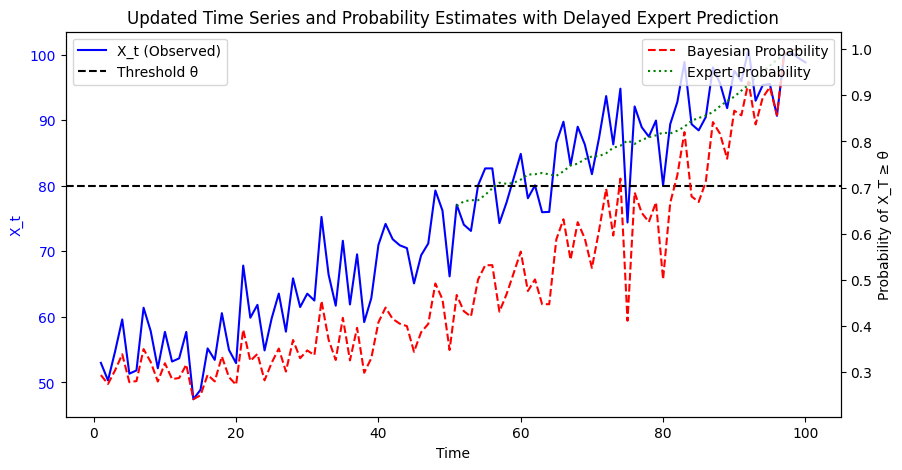

In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters
T = 100  # Total time periods
theta = 80  # Threshold value
alpha = 50  # Intercept
beta = 0.5  # Trend coefficient
sigma = 5  # Standard deviation of noise
# Updated Parameters
T_train = 50  # Training period before expert model starts predicting
T_total = 100  # Total time periods

# Generate the full series X_t
np.random.seed(42)
t_values = np.arange(1, T_total + 1)
epsilon = np.random.normal(0, sigma, T_total)
X_t = alpha + beta * t_values + epsilon

# Initialize probability estimates
p_bayesian = np.full(T_total, np.nan)
p_expert = np.full(T_total, np.nan)

# Compute Bayesian trader probability estimate for all periods
p_bayesian[:] = 1 - stats.norm.cdf((theta - X_t) / (sigma * np.sqrt(T_total - t_values)))

# Compute Expert trader probability estimate only after T_train observations
for t in range(T_train, T_total):
    # Fit a rolling regression using past observations
    X_past = np.vstack([np.ones(t), t_values[:t]]).T
    theta_hat = np.linalg.lstsq(X_past, X_t[:t], rcond=None)[0]

    # Predict X_T from the estimated trend
    X_T_pred = theta_hat[0] + theta_hat[1] * T_total
    p_expert[t] = 1 - stats.norm.cdf((theta - X_T_pred) / (sigma * np.sqrt(T_total - t_values[t])))

# Create a DataFrame to store results
df = pd.DataFrame({
    't': t_values,
    'X_t': X_t,
    'p_bayesian': p_bayesian,
    'p_expert': p_expert
})


# Plot the updated series and probability estimates
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot X_t
ax1.plot(t_values, X_t, label='X_t (Observed)', color='blue')
ax1.axhline(theta, color='black', linestyle='--', label='Threshold θ')
ax1.set_xlabel('Time')
ax1.set_ylabel('X_t', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot probabilities on a secondary axis
ax2 = ax1.twinx()
ax2.plot(t_values, p_bayesian, label='Bayesian Probability', color='red', linestyle='dashed')
ax2.plot(t_values, p_expert, label='Expert Probability', color='green', linestyle='dotted')
ax2.set_ylabel('Probability of X_T ≥ θ', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Updated Time Series and Probability Estimates with Delayed Expert Prediction")
plt.show()


     Trader  Mean Log Loss  Mean Brier Score
0  Bayesian       0.001031      1.158340e-05
1    Expert       0.000045      4.606846e-09


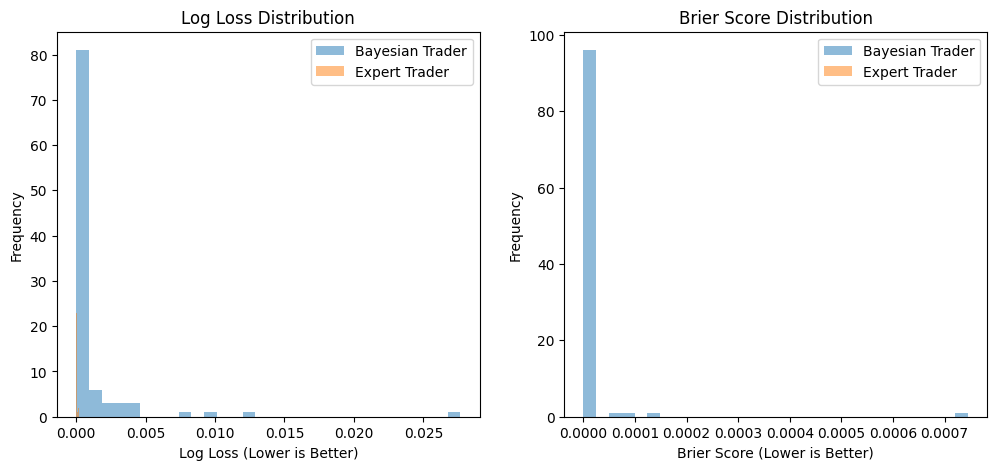

In [16]:
# Simulation Parameters
num_simulations = 100  # Number of simulations
T_train = 50  # Training period before expert model starts predicting
T_total = 100  # Total time periods
theta = 120  # Threshold
alpha = 50  # Intercept
beta = 0.5  # Trend coefficient
sigma = 5  # Standard deviation of noise

from sklearn.metrics import log_loss, brier_score_loss
# Store scores
log_loss_bayesian = []
log_loss_expert = []
brier_score_bayesian = []
brier_score_expert = []

for sim in range(num_simulations):
    # Generate a new time series X_t
    t_values = np.arange(1, T_total + 1)
    epsilon = np.random.normal(0, sigma, T_total)
    X_t = alpha + beta * t_values + epsilon

    # Compute actual outcome
    s_realized = int(X_t[-1] >= theta)

    # Compute Bayesian trader probability estimate
    p_bayesian = 1 - stats.norm.cdf((theta - X_t) / (sigma * np.sqrt(np.maximum(1, T_total - t_values))))

    # Compute Expert trader probability estimate only after T_train
    p_expert = np.full(T_total, np.nan)
    for t in range(T_train, T_total):
        X_past = np.vstack([np.ones(t), t_values[:t]]).T
        theta_hat = np.linalg.lstsq(X_past, X_t[:t], rcond=None)[0]
        X_T_pred = theta_hat[0] + theta_hat[1] * T_total
        p_expert[t] = 1 - stats.norm.cdf((theta - X_T_pred) / (sigma * np.sqrt(np.maximum(1, T_total - t_values[t]))))

    # Get final predictions, clipping probabilities to avoid log(0) issues
    final_p_bayesian = np.clip(p_bayesian[-1], 1e-6, 1 - 1e-6)
    final_p_expert = np.clip(p_expert[-1], 1e-6, 1 - 1e-6)

    # Compute Log Loss (explicitly defining class labels)
    log_loss_bayesian.append(log_loss([s_realized], [[1 - final_p_bayesian, final_p_bayesian]], labels=[0, 1]))
    log_loss_expert.append(log_loss([s_realized], [[1 - final_p_expert, final_p_expert]], labels=[0, 1]))

    # Compute Brier Score
    brier_score_bayesian.append(brier_score_loss([s_realized], [final_p_bayesian]))
    brier_score_expert.append(brier_score_loss([s_realized], [final_p_expert]))

# Compute mean scores
mean_log_loss_bayesian = np.mean(log_loss_bayesian)
mean_log_loss_expert = np.mean(log_loss_expert)
mean_brier_bayesian = np.mean(brier_score_bayesian)
mean_brier_expert = np.mean(brier_score_expert)

# Display results
accuracy_df = pd.DataFrame({
    'Trader': ['Bayesian', 'Expert'],
    'Mean Log Loss': [mean_log_loss_bayesian, mean_log_loss_expert],
    'Mean Brier Score': [mean_brier_bayesian, mean_brier_expert]
})

print(accuracy_df)
# Plot distributions of log loss and Brier score
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Log Loss Histogram
axs[0].hist(log_loss_bayesian, bins=30, alpha=0.5, label='Bayesian Trader')
axs[0].hist(log_loss_expert, bins=30, alpha=0.5, label='Expert Trader')
axs[0].set_xlabel('Log Loss (Lower is Better)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Log Loss Distribution')
axs[0].legend()

# Brier Score Histogram
axs[1].hist(brier_score_bayesian, bins=30, alpha=0.5, label='Bayesian Trader')
axs[1].hist(brier_score_expert, bins=30, alpha=0.5, label='Expert Trader')
axs[1].set_xlabel('Brier Score (Lower is Better)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Brier Score Distribution')
axs[1].legend()

plt.show()

In [17]:
# Empirical probability of the series exceeding the threshold
num_simulations = 1000  # Number of simulations
cross_threshold_count = 0

for sim in range(num_simulations):
    # Generate a new time series X_t
    t_values = np.arange(1, T_total + 1)
    epsilon = np.random.normal(0, sigma, T_total)
    X_t = alpha + beta * t_values + epsilon

    # Check if the final value exceeds the threshold
    if X_t[-1] >= theta:
        cross_threshold_count += 1

# Compute empirical probability
empirical_prob = cross_threshold_count / num_simulations

# Display result
empirical_prob_df = pd.DataFrame({
    'Metric': ['Empirical Probability of Exceeding Threshold'],
    'Value': [empirical_prob]
})

print(empirical_prob_df)

                                         Metric  Value
0  Empirical Probability of Exceeding Threshold    0.0


In [27]:
import sys
!{sys.executable} -m pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip3.12 install --upgrade pip


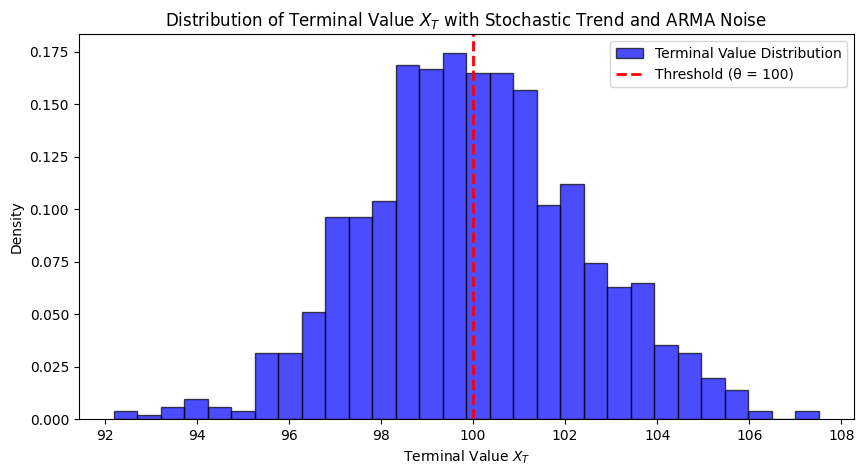

In [33]:
from statsmodels.tsa.arima_process import ArmaProcess

# Define ARMA process parameters
ar_params = np.array([0.5, -0.3])  # AR coefficients (excluding lag 0 term)
ma_params = np.array([0.4])  # MA coefficient

# Convert to the format expected by ArmaProcess (prepend 1 for AR, MA)
ar = np.r_[1, -ar_params]  # Add leading 1 for AR lag 0
ma = np.r_[1, ma_params]  # Add leading 1 for MA lag 0

# Create ARMA process
arma_process = ArmaProcess(ar, ma)
# Simulate ARMA process with a stochastic trend (Random Walk + ARMA)
num_simulations = 1000
T_total = 100  # Number of periods
theta = 100  # Threshold
# Parameters for stochastic trend
sigma_gamma = 0.2  # Standard deviation of the stochastic trend component
alpha = 50  # Intercept

# Simulate ARMA process with a stochastic trend (Random Walk with Drift + ARMA + Stochastic Drift)
X_T_values = []

for sim in range(num_simulations):
    # Generate ARMA component
    arma_component = arma_process.generate_sample(nsample=T_total)

    # Generate stochastic trend with varying drift
    gamma_t = np.random.normal(0, sigma_gamma, T_total)  # Stochastic drift
    stochastic_trend = np.cumsum(beta + gamma_t)  # Cumulative trend with stochastic drift

    # Combine both components
    X_t = alpha + stochastic_trend + arma_component

    X_T_values.append(X_t[-1])  # Store the terminal value

# Convert to numpy array for analysis
X_T_values = np.array(X_T_values)

# Plot histogram of terminal values
plt.figure(figsize=(10, 5))
plt.hist(X_T_values, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True, label="Terminal Value Distribution")

# Add vertical line for threshold
plt.axvline(theta, color='red', linestyle='dashed', linewidth=2, label=f"Threshold (θ = {theta})")

# Labels and title
plt.xlabel("Terminal Value $X_T$")
plt.ylabel("Density")
plt.title("Distribution of Terminal Value $X_T$ with Stochastic Trend and ARMA Noise")
plt.legend()
plt.show()



<>:36: SyntaxWarning: invalid escape sequence '\h'
<>:38: SyntaxWarning: invalid escape sequence '\h'
<>:36: SyntaxWarning: invalid escape sequence '\h'
<>:38: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_9755/1491585975.py:36: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("First Predicted Terminal Value $\hat{X}_T$")
/tmp/ipykernel_9755/1491585975.py:38: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Distribution of Expert's First Predicted Terminal Value $\hat{X}_T$ Across Simulations")


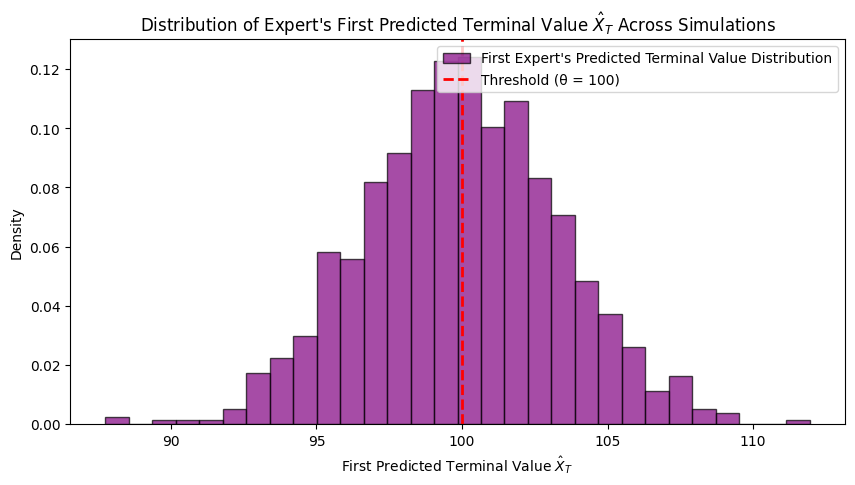

In [37]:
# Store first-date predicted terminal values from the Expert trader
X_T_expert_initial_predictions = []

for sim in range(num_simulations):
    # Generate ARMA component
    arma_component = arma_process.generate_sample(nsample=T_total)

    # Generate stochastic trend with varying drift
    gamma_t = np.random.normal(0, sigma_gamma, T_total)  # Stochastic drift
    stochastic_trend = np.cumsum(beta + gamma_t)  # Cumulative trend with stochastic drift

    # Combine both components
    X_t = alpha + stochastic_trend + arma_component

    # Expert trader's first available prediction (from T_train)
    X_T_pred = np.nan  # Default in case T_train condition is not met

    if T_train < T_total:
        X_past = np.vstack([np.ones(T_train), np.arange(1, T_train + 1)]).T  # Design matrix for linear regression
        theta_hat = np.linalg.lstsq(X_past, X_t[:T_train], rcond=None)[0]  # Linear regression coefficients
        X_T_pred = theta_hat[0] + theta_hat[1] * T_total  # First available expert forecast

    X_T_expert_initial_predictions.append(X_T_pred)  # Store the first prediction

# Convert to numpy array for analysis
X_T_expert_initial_predictions = np.array(X_T_expert_initial_predictions)

# Plot histogram of first-date predicted terminal values by Expert trader
plt.figure(figsize=(10, 5))
plt.hist(X_T_expert_initial_predictions, bins=30, alpha=0.7, color='purple', edgecolor='black', density=True, label="First Expert's Predicted Terminal Value Distribution")

# Add vertical line for threshold
plt.axvline(theta, color='red', linestyle='dashed', linewidth=2, label=f"Threshold (θ = {theta})")

# Labels and title
plt.xlabel("First Predicted Terminal Value $\hat{X}_T$")
plt.ylabel("Density")
plt.title("Distribution of Expert's First Predicted Terminal Value $\hat{X}_T$ Across Simulations")
plt.legend()
plt.show()


<>:40: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\h'
<>:40: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_9755/173151721.py:40: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("First Predicted Terminal Value $\hat{X}_T$ (Naive)")
/tmp/ipykernel_9755/173151721.py:42: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Distribution of Bayesian Trader's First Predicted Terminal Value $\hat{X}_T$ Across Simulations")


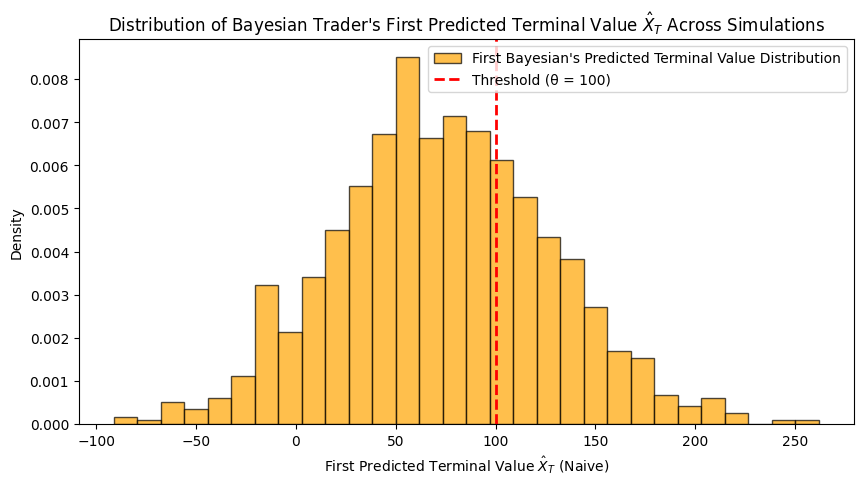

In [39]:
# Store first-date predicted terminal values from the Bayesian (naive) trader
X_T_bayesian_initial_predictions = []

for sim in range(num_simulations):
    # Generate ARMA component
    arma_component = arma_process.generate_sample(nsample=T_total)

    # Generate stochastic trend with varying drift
    gamma_t = np.random.normal(0, sigma_gamma, T_total)  # Stochastic drift
    stochastic_trend = np.cumsum(beta + gamma_t)  # Cumulative trend with stochastic drift

    # Combine both components
    X_t = alpha + stochastic_trend + arma_component

    # Bayesian trader's first available prediction (from T_train)
    X_T_pred = np.nan  # Default in case T_train condition is not met

    if T_train < T_total:
        # Bayesian trader assumes X_T follows a normal distribution centered at X_TRAIN
        X_T_pred = X_t[T_train - 1]  # Mean assumption
        remaining_time = T_total - T_train
        sigma_future = np.std(X_t[:T_train]) * np.sqrt(remaining_time)  # Scaling std deviation
        
        # Bayesian trader's expected terminal value (considering future variance)
        X_T_pred += np.random.normal(0, sigma_future)  # Adding Gaussian noise based on estimated variance

    X_T_bayesian_initial_predictions.append(X_T_pred)  # Store the first prediction

# Convert to numpy array for analysis
X_T_bayesian_initial_predictions = np.array(X_T_bayesian_initial_predictions)

# Plot histogram of first-date predicted terminal values by Bayesian trader
plt.figure(figsize=(10, 5))
plt.hist(X_T_bayesian_initial_predictions, bins=30, alpha=0.7, color='orange', edgecolor='black', density=True, label="First Bayesian's Predicted Terminal Value Distribution")

# Add vertical line for threshold
plt.axvline(theta, color='red', linestyle='dashed', linewidth=2, label=f"Threshold (θ = {theta})")

# Labels and title
plt.xlabel("First Predicted Terminal Value $\hat{X}_T$ (Naive)")
plt.ylabel("Density")
plt.title("Distribution of Bayesian Trader's First Predicted Terminal Value $\hat{X}_T$ Across Simulations")
plt.legend()
plt.show()


     Trader  Mean Log Loss  Mean Brier Score
0  Bayesian       0.450768          0.136423
1    Expert       0.534398          0.175471


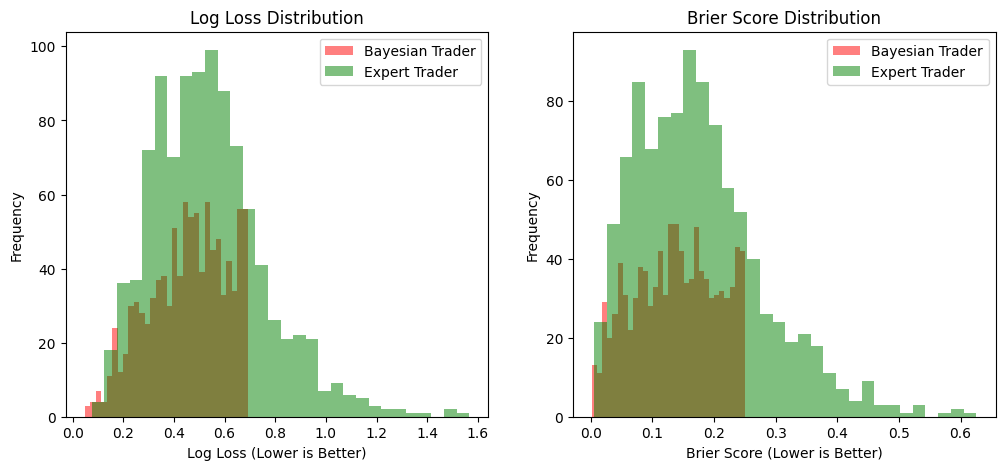

In [35]:
# Store predictions and evaluation metrics
log_loss_bayesian = []
log_loss_expert = []
brier_score_bayesian = []
brier_score_expert = []

for sim in range(num_simulations):
    # Generate ARMA component
    arma_component = arma_process.generate_sample(nsample=T_total)

    # Generate stochastic trend with varying drift
    gamma_t = np.random.normal(0, sigma_gamma, T_total)  # Stochastic drift
    stochastic_trend = np.cumsum(beta + gamma_t)  # Cumulative trend with stochastic drift

    # Combine both components
    X_t = alpha + stochastic_trend + arma_component

    # Compute actual outcome (whether X_T exceeds the threshold)
    s_realized = int(X_t[-1] >= theta)

    # Compute Bayesian trader probability estimate
    p_bayesian = 1 - stats.norm.cdf((theta - X_t) / (sigma * np.sqrt(np.maximum(1, T_total - np.arange(1, T_total + 1)))))

    # Compute Expert trader probability estimate using a linear regression trend
    p_expert = np.full(T_total, np.nan)
    for t in range(T_train, T_total):
        X_past = np.vstack([np.ones(t), np.arange(1, t + 1)]).T  # Design matrix for linear regression
        theta_hat = np.linalg.lstsq(X_past, X_t[:t], rcond=None)[0]  # Linear regression coefficients
        X_T_pred = theta_hat[0] + theta_hat[1] * T_total  # Expert forecast for X_T
        p_expert[t] = 1 - stats.norm.cdf((theta - X_T_pred) / (sigma * np.sqrt(np.maximum(1, T_total - t))))

    # Get final probability estimates
    final_p_bayesian = np.clip(p_bayesian[-1], 1e-6, 1 - 1e-6)
    final_p_expert = np.clip(p_expert[-1], 1e-6, 1 - 1e-6)

    # Compute Log Loss (explicitly defining class labels)
    log_loss_bayesian.append(log_loss([s_realized], [[1 - final_p_bayesian, final_p_bayesian]], labels=[0, 1]))
    log_loss_expert.append(log_loss([s_realized], [[1 - final_p_expert, final_p_expert]], labels=[0, 1]))

    # Compute Brier Score
    brier_score_bayesian.append(brier_score_loss([s_realized], [final_p_bayesian]))
    brier_score_expert.append(brier_score_loss([s_realized], [final_p_expert]))

# Compute mean scores
mean_log_loss_bayesian = np.mean(log_loss_bayesian)
mean_log_loss_expert = np.mean(log_loss_expert)
mean_brier_bayesian = np.mean(brier_score_bayesian)
mean_brier_expert = np.mean(brier_score_expert)

# Display results
accuracy_df = pd.DataFrame({
    'Trader': ['Bayesian', 'Expert'],
    'Mean Log Loss': [mean_log_loss_bayesian, mean_log_loss_expert],
    'Mean Brier Score': [mean_brier_bayesian, mean_brier_expert]
})


print(accuracy_df)
# Plot distributions of log loss and Brier score
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Log Loss Histogram
axs[0].hist(log_loss_bayesian, bins=30, alpha=0.5, label='Bayesian Trader', color='red')
axs[0].hist(log_loss_expert, bins=30, alpha=0.5, label='Expert Trader', color='green')
axs[0].set_xlabel('Log Loss (Lower is Better)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Log Loss Distribution')
axs[0].legend()

# Brier Score Histogram
axs[1].hist(brier_score_bayesian, bins=30, alpha=0.5, label='Bayesian Trader', color='red')
axs[1].hist(brier_score_expert, bins=30, alpha=0.5, label='Expert Trader', color='green')
axs[1].set_xlabel('Brier Score (Lower is Better)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Brier Score Distribution')
axs[1].legend()

plt.show()


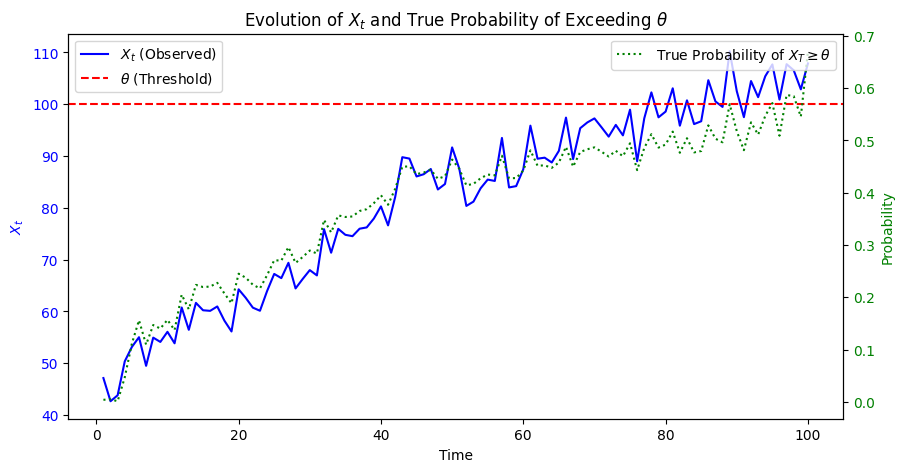

In [81]:
# Define a new process with deterministic and stochastic components
T_total = 100  # Number of periods
theta = 100  # Threshold for event occurrence

# Parameters
alpha = 50  # Intercept
beta = 0.5  # Linear deterministic trend component
sigma_stochastic = 2  # Standard deviation for stochastic component
sigma_noise = 3  # Standard deviation for noise component

# Generate deterministic component
t_values = np.arange(1, T_total + 1)
deterministic_trend = alpha + beta * t_values  # Linear trend

# Generate stochastic component as a random walk
stochastic_component = np.cumsum(np.random.normal(0, sigma_stochastic, T_total))

# Generate noise
noise = np.random.normal(0, sigma_noise, T_total)

# Combine to form X_t process
X_t = deterministic_trend + stochastic_component + noise

# Compute the true probability at each time step that X_T exceeds theta
true_probabilities = np.zeros(T_total)

for t in range(T_total):
    remaining_time = T_total - t
    sigma_future = np.std(X_t[:t+1]) * np.sqrt(remaining_time) if t > 0 else sigma_stochastic * np.sqrt(remaining_time)
    
    true_probabilities[t] = 1 - stats.norm.cdf((theta - X_t[t]) / sigma_future)

# Plot X_t and true probability evolution
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot X_t
ax1.plot(t_values, X_t, label='$X_t$ (Observed)', color='blue')
ax1.axhline(theta, color='red', linestyle='--', label='$\\theta$ (Threshold)')
ax1.set_xlabel('Time')
ax1.set_ylabel('$X_t$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot probabilities on a secondary axis
ax2 = ax1.twinx()
ax2.plot(t_values, true_probabilities, label='True Probability of $X_T \\geq \\theta$', color='green', linestyle='dotted')
ax2.set_ylabel('Probability', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Evolution of $X_t$ and True Probability of Exceeding $\\theta$")
plt.show()


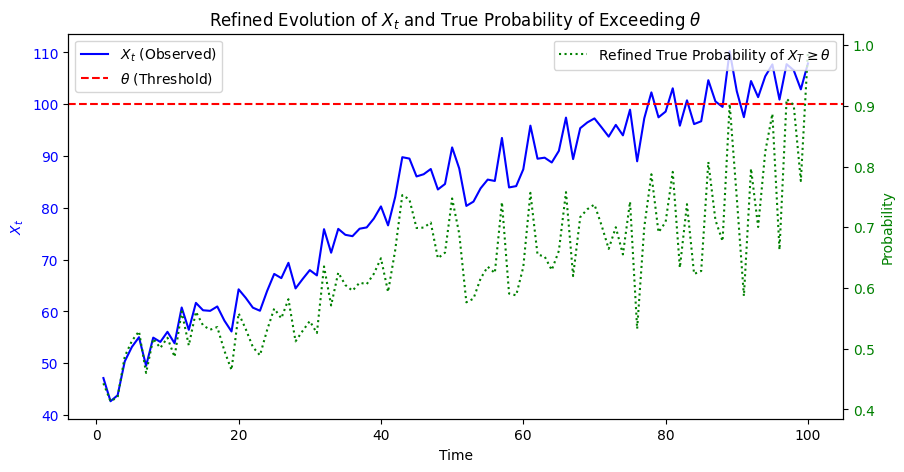

In [100]:
# Compute the refined true probability that X_T exceeds theta

# Initialize the refined probability array
true_probabilities= np.zeros(T_total)

for t in range(T_total):
    remaining_time = T_total - t

    if t == 0:
        # Initial estimate: use stochastic component variance
        sigma_future = sigma_stochastic * np.sqrt(remaining_time)
        expected_X_T = X_t[t] + remaining_time * beta  # Expectation with deterministic trend
    else:
        # Estimate future variance considering stochastic drift + noise
        sigma_future = np.sqrt(
            (sigma_stochastic**2) * remaining_time + (sigma_noise**2) * remaining_time
        )
        # Expectation follows the deterministic trend plus estimated stochastic component drift
        expected_X_T = X_t[t] + remaining_time * beta  # Linear drift expectation

    # Compute refined probability using updated expectation and variance
    true_probabilities[t] = 1 - stats.norm.cdf((theta - expected_X_T) / sigma_future)

# Plot X_t and refined true probability evolution
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot X_t
ax1.plot(t_values, X_t, label='$X_t$ (Observed)', color='blue')
ax1.axhline(theta, color='red', linestyle='--', label='$\\theta$ (Threshold)')
ax1.set_xlabel('Time')
ax1.set_ylabel('$X_t$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot refined probabilities on a secondary axis
ax2 = ax1.twinx()
ax2.plot(t_values, true_probabilities, label='Refined True Probability of $X_T \\geq \\theta$', color='green', linestyle='dotted')
ax2.set_ylabel('Probability', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Refined Evolution of $X_t$ and True Probability of Exceeding $\\theta$")
plt.show()


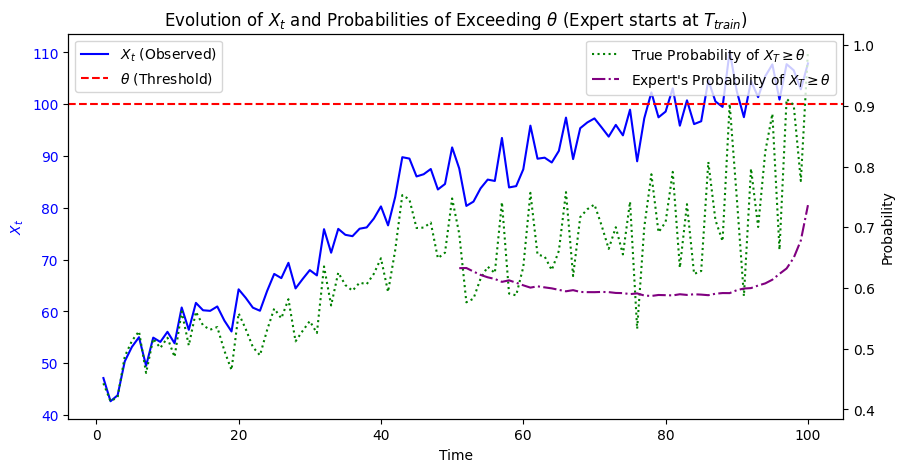

In [101]:
# Store expert trader's estimated probability at each time t, only after T_train
expert_probabilities = np.full(T_total, np.nan)  # Initialize with NaN for periods before T_train

for t in range(T_train, T_total):
    # Fit linear regression on past data to estimate trend
    X_past = np.vstack([np.ones(t), t_values[:t]]).T  # Design matrix for linear regression
    theta_hat = np.linalg.lstsq(X_past, X_t[:t], rcond=None)[0]  # Linear regression coefficients

    # Expert's estimated terminal value
    X_T_expert_pred = theta_hat[0] + theta_hat[1] * T_total

    # Estimate probability of exceeding threshold
    remaining_time = T_total - t
    sigma_future = np.std(X_t[:t+1]) * np.sqrt(remaining_time) if t > 0 else sigma_stochastic * np.sqrt(remaining_time)
    
    expert_probabilities[t] = 1 - stats.norm.cdf((theta - X_T_expert_pred) / sigma_future)

# Plot X_t, true probability, and expert's probability evolution
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot X_t
ax1.plot(t_values, X_t, label='$X_t$ (Observed)', color='blue')
ax1.axhline(theta, color='red', linestyle='--', label='$\\theta$ (Threshold)')
ax1.set_xlabel('Time')
ax1.set_ylabel('$X_t$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot probabilities on a secondary axis
ax2 = ax1.twinx()
ax2.plot(t_values, true_probabilities, label='True Probability of $X_T \\geq \\theta$', color='green', linestyle='dotted')
ax2.plot(t_values, expert_probabilities, label="Expert's Probability of $X_T \\geq \\theta$", color='purple', linestyle='dashdot')
ax2.set_ylabel('Probability', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Evolution of $X_t$ and Probabilities of Exceeding $\\theta$ (Expert starts at $T_{train}$)")
plt.show()


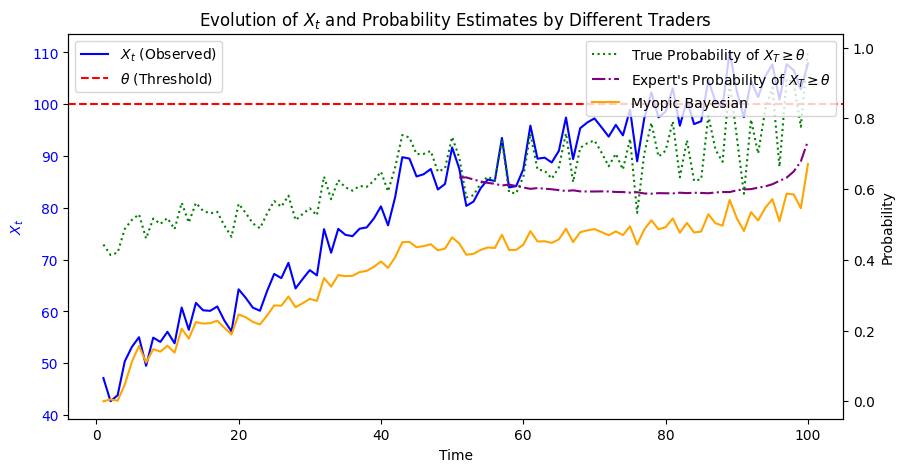

In [102]:
# Initialize arrays for naive traders' probability estimates
myopic_bayesian_probabilities = np.zeros(T_total)  # Last-value Bayesian update
smooth_naive_probabilities = np.zeros(T_total)  # Weighted average trader
mean_reverter_probabilities = np.zeros(T_total)  # Historical mean trader

# Smoothing parameter for the weighted average trader
lambda_smooth = 0.7

# Initialize historical mean
historical_mean = X_t[0]

for t in range(1, T_total):
    remaining_time = T_total - t
    sigma_future = np.std(X_t[:t+1]) * np.sqrt(remaining_time) if t > 0 else sigma_stochastic * np.sqrt(remaining_time)

    # 1. Myopic Bayesian (uses last observed X_t)
    myopic_bayesian_probabilities[t] = 1 - stats.norm.cdf((theta - X_t[t]) / sigma_future)

    # 2. Smooth Naive (exponential weighted moving average)
    if t == 1:
        X_smooth = X_t[t]  # Initialize smoothing with first observation
    else:
        X_smooth = lambda_smooth * X_t[t] + (1 - lambda_smooth) * X_smooth
    
    smooth_naive_probabilities[t] = 1 - stats.norm.cdf((theta - X_smooth) / sigma_future)

    # 3. Mean Reverter (historical average)
    historical_mean = (historical_mean * (t - 1) + X_t[t]) / t
    mean_reverter_probabilities[t] = 1 - stats.norm.cdf((theta - historical_mean) / sigma_future)

# Plot X_t, true probability, expert, and naive traders' probability evolution
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot X_t
ax1.plot(t_values, X_t, label='$X_t$ (Observed)', color='blue')
ax1.axhline(theta, color='red', linestyle='--', label='$\\theta$ (Threshold)')
ax1.set_xlabel('Time')
ax1.set_ylabel('$X_t$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot probabilities on a secondary axis
ax2 = ax1.twinx()
ax2.plot(t_values, true_probabilities, label='True Probability of $X_T \\geq \\theta$', color='green', linestyle='dotted')
ax2.plot(t_values, expert_probabilities, label="Expert's Probability of $X_T \\geq \\theta$", color='purple', linestyle='dashdot')
ax2.plot(t_values, myopic_bayesian_probabilities, label="Myopic Bayesian", color='orange', linestyle='solid')
# ax2.plot(t_values, smooth_naive_probabilities, label="Smooth Naive", color='brown', linestyle='dashed')
# ax2.plot(t_values, mean_reverter_probabilities, label="Mean Reverter", color='gray', linestyle='dashdot')
ax2.set_ylabel('Probability', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Evolution of $X_t$ and Probability Estimates by Different Traders")
plt.show()
